## Urban Development and Biodiversity in Phoenix

### Purpose

The purpose of this exercise is to learn about calculating values from rasters in specific regions using python. We will do this by taking a look at the loss in Biodiversity in Phoenix, Arizona.

### Background

In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001 [1]. This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems. This analysis utilizes the Biodiversity Intactness Index (BII), a metric that estimates the remaining proportion of native species in an area compared to an undisturbed baseline. BII provides a way to quantify the impact of human activities, such as urban development, on local biodiversity. By quantifying the impact of human activities, we can get a better idea of the sustainability of development in rural and urban areas, and in turn give ourselves tools to improve our relationship with our natural environment.


### Highlights
 1) Reading in data from Microsoft's Planetary Computer
 2) Matching CRS to combine raster and shapefile data
 3) Calculating raster percentages
 4) Calculating and visualizing % change in rasters between years

### Data
 - Biodiversity Intactness Index (BII) Time Series
 Source: https://planetarycomputer.microsoft.com/dataset/io-biodiversity
 
 
 - Arizona State Count Subdivision Shapefile
 Source: https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision


### Load in Libraries

In [69]:
import pandas as pd
import geopandas as gpd
import os
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap


from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

### Read in Data

In [31]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Pull out biodiversity collections
bdi_collection = catalog.get_child('io-biodiversity')

In [32]:
# Read in Arizona shapefile
arizona = gpd.read_file(os.path.join('data',
                  'tl_2024_04_cousub',
                  'tl_2024_04_cousub.shp'
                 ))

# Check CRS
print(f"arizona crs is: {arizona.crs}")

arizona crs is: EPSG:4269


### Arizona Shapefile Data Filtering

For our analysis, we only want to look at changes in biodiversity in the Phoenix subdivsion. First, let's explore our data a bit to see where we might want to target our filter
 

In [33]:
# Print first 5 rows of data
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


Looks like we'll be able to specify Phoenix from our `Name` column. Let's do that by indexing into the dataset with `df[df['Column'] == 'Value'`

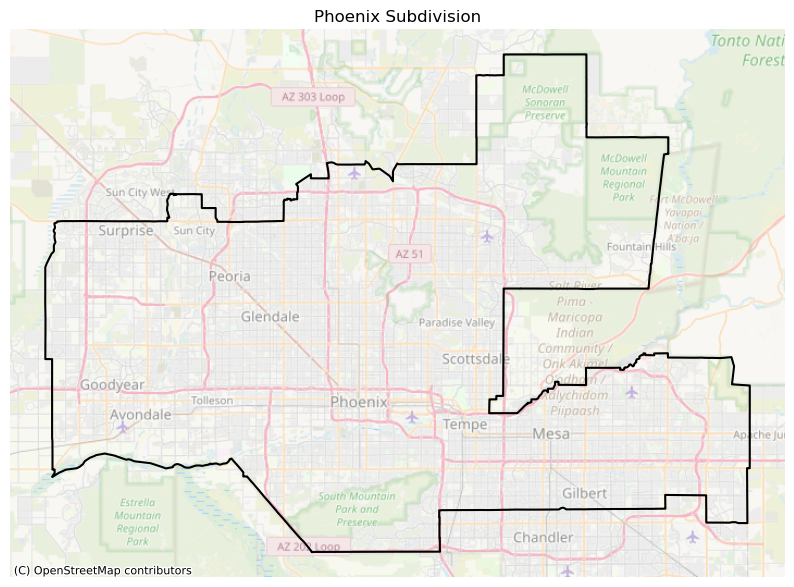

In [34]:
# Filter Phoenix
phoenix = arizona[arizona['NAME'] == 'Phoenix']

# Reproject to Web Mercator (EPSG:3857) for use with basemap
phoenix_web_mercator = phoenix.to_crs(epsg=3857)

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
phoenix_web_mercator.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

# Remove axes
ax.set_axis_off()

# Add OpenStreetMap basemap with transparency
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.axes.set_title('Phoenix Subdivision')

plt.show()

Now, let's create a bounding box for our Arizona shapefile. It will help us access our BII data later.

In [35]:
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]


### Biodiversity Data Filtering

We want to select our BII Data for our specified dates, and our specified bounds, we'll do that using the `search()` method for our `catalog` object

In [36]:
search = catalog.search(collections=["io-biodiversity"],
                        bbox=bbox,
                        datetime = "2017-01-01/2020-01-01")

# Extract items from search
items = list(search.items())

# Extract number of items in search
len(items)

4

### Data Exploration

#### Let's look at a single raster

The BII data is available at the item’s `data` asset. Use `rioxr.open_rasterio` to open the data asset. We want to open `item.assets['data'].href` to get the xarray. 

In [37]:
# Isolate image from 2017
item_2017 = items[3]

# Isolate image from 2020
item_2020 = items[0]

# Access data for 2017
item_data_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
item_data_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### What does this tell us?
Our data only has 1 band, and our area of coverage is much larger than our Phoenix subdivision. Let's see if we get similar result for our 2020 data.

In [38]:
item_data_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
item_data_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Now let's take a look at what our data values look like

In [39]:
# Access the number of bands, rows, and columns for each dataset
print(f"BII 2017 data item the following number of (bands, rows, columns):{item_data_2017.shape}")
print(f"BII 2020 data item the following number of (bands, rows, columns):{item_data_2020.shape}")


item_data_2017.shape

BII 2017 data item the following number of (bands, rows, columns):(1, 7992, 7992)
BII 2020 data item the following number of (bands, rows, columns):(1, 7992, 7992)


(1, 7992, 7992)

### Clipping BII data to `phoenix` extent

Now that we've access the BII data for both dates, let's clip our BII data to our `phoenix` gdb using the `rio.clip_box()` method for our isolated data. First, we'll needt to **Match our CRSs**

In [40]:
# Check CRS for all objects
print(f"CRS for item_data_2017 is: {item_data_2017.rio.crs}")
print(f"CRS for item_data_2020 is: {item_data_2020.rio.crs}")
print(f"CRS for phoenix is: {phoenix.crs}")

CRS for item_data_2017 is: EPSG:4326
CRS for item_data_2020 is: EPSG:4326
CRS for phoenix is: EPSG:4269


#### **Changing CRS**
We've got some inconsistencies with our CRS, so let's change our `phoenix` CRS to that of our `item_data_2017` using the `to_crs` method. By using the `inplace = True` argument we overwrite our phoenix data without having to create a new object. This will cause a warning. That's okay.

In [41]:
# Change phoenix CRS
phoenix.to_crs(item_data_2017.rio.crs, inplace = True)

# Check if it worked.
assert phoenix.crs == item_data_2017.rio.crs
assert phoenix.crs == item_data_2020.rio.crs

/Users/henryoliver/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### **Clip**

Now it's time to clip. We'll use the `rio.clip()` method to clip our BII data to our phoenix geometry. This step will take some time to run, but it's worth it I promise.

In [42]:
# Clip for 2017
BII_2017_clipped = item_data_2017.rio.clip(phoenix.geometry, phoenix.crs)

# Clip for 2020
BII_2020_clipped = item_data_2020.rio.clip(phoenix.geometry, phoenix.crs)

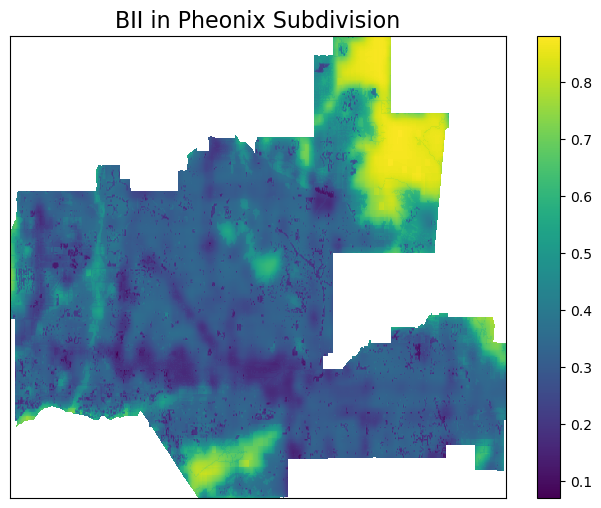

In [43]:
# Check if our clip worked
# Set up axes
fig, ax = plt.subplots(figsize=(8, 6))
BII_2017_clipped.plot(ax=ax)  # Plot BII

# Removes axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Title
ax.set_title("BII in Pheonix Subdivision", fontsize = 16)
plt.show()

### BII Calculations for 2017 and 2020

We want to find out the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017, and 2020. Let's go step by step for how we'll obtain that.

##### **1) Create a boolean mask to identify pixels greater than 0.75**

##### **2) Count the number of `True` pixels**

##### **3) Count the total number of pixels in the raster**

##### **4) Compute percentage of `True` to Total pixels**

##### **5) Repeat for 2020**

In [44]:
# Create boolean mask to isolate values greater than 0.75
mask_2017 = BII_2017_clipped > 0.75

In [45]:
# Count number of 'True' pixels
true_2017 = mask_2017.sum().item()

In [46]:
# Count total pixels
total_2017 = BII_2017_clipped.notnull().sum().item()

In [47]:
# Compute percentage
pct_2017 = 100 * true_2017 / total_2017
# Print answer
print(f"Percentage of pixels greater than 0.75 for 2017 is: {pct_2017:.2f}%")

Percentage of pixels greater than 0.75 for 2017 is: 7.13%


In [48]:
# Repeat steps for 2020
mask_2020 = BII_2020_clipped > 0.75
true_2020 = mask_2020.sum().item()
total_2020 = BII_2020_clipped.notnull().sum().item()
pct_2020 = 100 * true_2020 / total_2020
print(f"Percentage of pixels greater than 0.75 for 2020 is: {pct_2020:.2f}%")

Percentage of pixels greater than 0.75 for 2020 is: 6.49%


### Create Visualization of Lost Biodiversity Intactness

For our final step, we want to show the area with BII >= 0.75 in 2017 that was lost by 2020. We'll do so in n steps

##### 1) Identify pixels that were lost between 2017 and 2020
We'll do this by looking at the intersection of our boolean masks for values that were `True` in 2017, but not in 2020.

In [49]:
loss_mask = mask_2017 & (~mask_2020)

##### 2) Convert boolean loss mask to numeric

In [50]:
loss_rast = loss_mask.astype(int)

##### 4) Isolate loss raster to only pixels that == 1

In [51]:
loss_rast_1 = loss_rast.where(loss_rast == 1)

##### 3) Plot on top of BII 2020

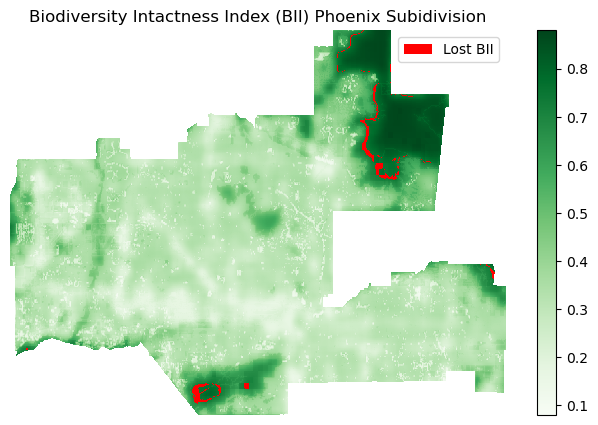

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Plot base raster (BII 2020)
BII_2020_clipped.plot(
    ax=ax,
    cmap='Greens',       # choose color
    add_colorbar=True
)

# Create a single-color red colormap
red_cmap = ListedColormap(['red'])

# Overlay loss raster in solid red
loss_rast_1.plot(
    ax=ax,
    cmap=red_cmap,
    add_colorbar=False,
    alpha=1
)


ax.axis('off')

# Add custom legend
legend_elements = [
    Patch(facecolor='red', label='Lost BII')
]
ax.legend(handles=legend_elements, loc='upper right') # Position legend

# Add title
ax.set_title('Biodiversity Intactness Index (BII) Phoenix Subidivision')

plt.show()

### Reflection

Between 2017 and 2020, the proportion of high-BII areas (≥0.75) in Phoenix declined from 7.13% to 6.49%, indicating a measurable loss of biodiversity intactness. The losses were concentrated in Northeast and South Phoenix, which are less densely populated, and appear to have higher BII than the rest of the subdivition. This pattern suggests that these areas may have experienced increased urban development or land-use changes between 2017-2020. Overall, the spatial distribution of BII loss highlights how development pressures in previously less disturbed regions can impact biodiversity.
